In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
file_path = '../Data_source/gym_members.csv'  # Update the file path if necessary
gym_data = pd.read_csv(file_path)

In [4]:
# Step 1: Data Preparation
# Encode Categorical Variables
encoder = LabelEncoder()
gym_data['Gender'] = encoder.fit_transform(gym_data['Gender'])  # Male=1, Female=0
gym_data['Workout_Type'] = encoder.fit_transform(gym_data['Workout_Type'])

In [5]:
# Scale Numerical Features
numerical_features = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 
    'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned', 
    'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'BMI'
]
scaler = StandardScaler()
gym_data[numerical_features] = scaler.fit_transform(gym_data[numerical_features])

In [6]:
# Split Data into Train and Test Sets
X = gym_data.drop(columns=['Workout_Type'])  # Features
y = gym_data['Workout_Type']               # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Step 2: Train the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Step 3: Evaluate the Model
# Predict on the test set
y_pred = rf_model.predict(X_test)

In [9]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 22.56%


In [10]:
# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.24      0.23        51
           1       0.22      0.18      0.20        44
           2       0.21      0.21      0.21        52
           3       0.25      0.27      0.26        48

    accuracy                           0.23       195
   macro avg       0.23      0.22      0.22       195
weighted avg       0.23      0.23      0.22       195



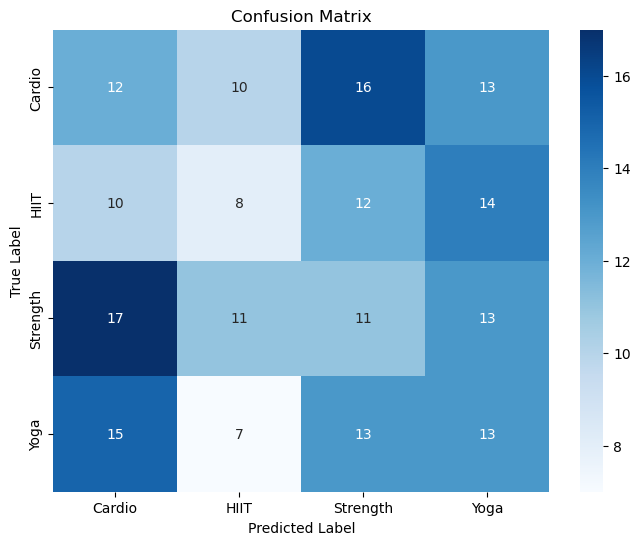

In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# Step 4: Analyze Feature Importance
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

In [13]:
# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

/var/folders/hr/3ykqsg891cngjjlr30f5yspr0000gn/T/ipykernel_14408/1110369562.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


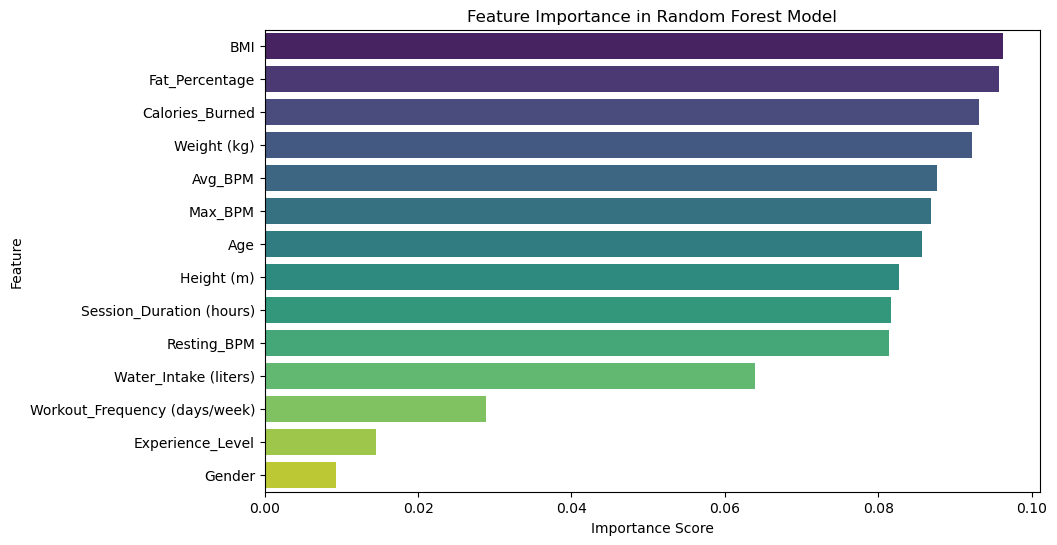

In [14]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [15]:
# Display the feature importance table
print("\nFeature Importances:\n", importance_df.reset_index(drop=True))


Feature Importances:
                           Feature  Importance
0                             BMI    0.096262
1                  Fat_Percentage    0.095730
2                 Calories_Burned    0.093181
3                     Weight (kg)    0.092188
4                         Avg_BPM    0.087662
5                         Max_BPM    0.086947
6                             Age    0.085673
7                      Height (m)    0.082710
8        Session_Duration (hours)    0.081653
9                     Resting_BPM    0.081442
10          Water_Intake (liters)    0.063970
11  Workout_Frequency (days/week)    0.028817
12               Experience_Level    0.014528
13                         Gender    0.009239


# Hyperparameter Tuning for model optimization

In [16]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [17]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='accuracy', 
                           verbose=2)

In [18]:
# Perform the grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_

/Users/gerardoochoa/anaconda3/envs/pandasplayground/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
308 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gerardoochoa/anaconda3/envs/pandasplayground/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gerardoochoa/anaconda3/envs/pandasplayground/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/gerardoochoa/anaconda3/envs/pandasplayground/lib/pyth

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [19]:
# Best parameters from GridSearch
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [20]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

In [21]:
# Accuracy and Classification Report
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Improved Accuracy: {best_accuracy * 100:.2f}%")

Improved Accuracy: 22.56%


In [22]:
class_report_best = classification_report(y_test, y_pred_best)
print("\nImproved Classification Report:\n", class_report_best)


Improved Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.24      0.23        51
           1       0.22      0.18      0.20        44
           2       0.21      0.21      0.21        52
           3       0.25      0.27      0.26        48

    accuracy                           0.23       195
   macro avg       0.23      0.22      0.22       195
weighted avg       0.23      0.23      0.22       195



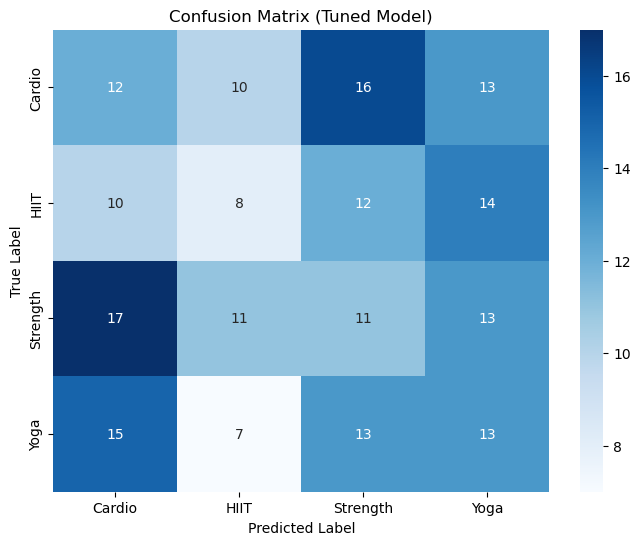

In [23]:
# Confusion Matrix for the tuned model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Tuned Model)")
plt.show()